In [7]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as Keras
from keras.applications import ResNet50

from sklearn import metrics
from scipy.spatial import distance

In [8]:
import sys
sys.path.insert(0, '/home/albert/github/DenseNet/')
import densenet

### Mine Triplets

In [9]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [10]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

In [11]:
print train_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_train/0575_c6s2_004068_01.jpg', 575]


In [12]:
print test_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_test/0152_c2s1_024601_02.jpg', 152]


### Train Network

In [13]:
# Number of identities
P_param = 4
# Number of images per identity
K_param = 4

In [14]:
def output_batch_generator(files_dict, labels, P=P_param, K=K_param):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            if K > len(files_dict[idt_choice[p]]):
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=True)
            else:
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=False)
            for k in k_choice:
                path = files_dict[idt_choice[p]][k]
                img = densenet.preprocess_input(cv2.resize(misc.imread(path), (128,256)).astype(np.float64))
                batch.append(img.tolist())
        output = np.array(batch)
        yield(output, np.zeros((P*K, 128)))

In [15]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [16]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2), axis=1)

In [17]:
def triplet_loss(y_true, y_pred, margin=0.5, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss / (P*K)

In [18]:
def evaluate_rank(net, rank, all_embeddings, all_identities, files_arr, test_iter=1000, shape=(256,128)):
    correct = 0
    f_choice = np.random.choice(range(len(files_arr)), np.minimum(test_iter, len(files_arr)), replace=False)
    for f in f_choice:
        query_img = densenet.preprocess_input(cv2.resize(misc.imread(files_arr[f][0]).astype(np.float64), 
                                                         (shape[1], shape[0])))
        query_embedding = net.predict(query_img.reshape(1, shape[0], shape[1], 3))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
        i = 0
        for c in output_classes:
            if c == int(files_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
    return float(correct)/test_iter

In [19]:
def pos_pair_generator(files_dict):
    while True:
        idt = np.random.choice(files_dict.keys(), 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(files_dict[idt])), np.minimum(2, len(files_dict[idt])), replace=False)
        pair = [files_dict[idt][p] for p in sample_choice]
        yield pair

In [20]:
def neg_pair_generator(files_dict):
    while True:
        idt_choice = np.random.choice(files_dict.keys(), 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(files_dict[idt])), 1, replace=False)[0]
            pair.append(files_dict[idt][sample])
        yield pair

In [21]:
def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

In [22]:
def evaluate_dist(model, generator, n_pairs=1000, train=False):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(densenet.preprocess_input(cv2.resize(misc.imread(pair[i]), (128,256)).astype(np.float64)).reshape(1,256,128,3)) 
                   for i in range(2)]
        dist = distance.cosine(predict[0], predict[1])
        distances.append(dist)
    return distances

According to the triplet loss paper, use an adaptive learning rate decay that is constant at first, then decays exponentially.

In [23]:
# https://medium.com/towards-data-science/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
def step_decay(epoch):
    initial_lr = 0.0003
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lr * np.power(drop,  
           np.floor((1+epoch)/epochs_drop))
    return lrate

def step_decay_cont(epoch, init_epoch, init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if 1 + epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((1 + epoch + init_epoch - t1)/(epochs_drop)))
    return lrate

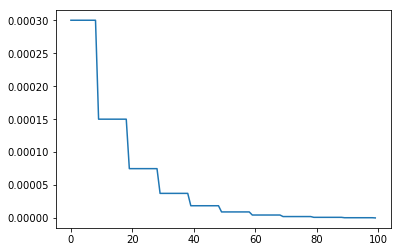

In [24]:
lr = []
for i in range(100):
    lr.append(step_decay(i))
plt.plot(np.arange(100), lr)

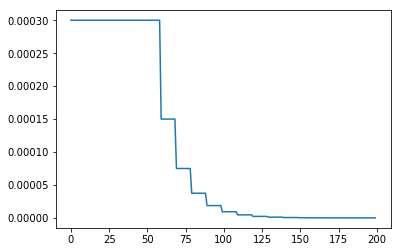

In [25]:
lr = []
for i in range(20):
    for j in range(10):
        lr.append(step_decay_cont(j, 10*i, 0.0003))
plt.plot(np.arange(200), lr)

In [26]:
def get_score(model, files_dict, files_arr, file_root, score, iterations, hist=False):
    all_embeddings = []
    all_identities = []
    for idt in files_dict.keys():
        for f in files_dict[idt]:
            img = densenet.preprocess_input(cv2.resize(misc.imread(f), (128,256)).astype(np.float64))
            predict = model.predict(img.reshape(1, 256, 128, 3))
            all_embeddings.append(predict)
            all_identities.append(idt)

    for rank in [1,5,20]:
        rank_arr = []
        for x in range(3):
            rank_score = evaluate_rank(trinet, rank, all_embeddings, 
                                       all_identities, files_arr, test_iter=1000)
            rank_arr.append(rank_score)
        score['rank%d' % rank][iterations] = rank_arr
    
    pos_generator = pos_pair_generator(files_dict)
    neg_generator = neg_pair_generator(files_dict)
    
    pos_distance = evaluate_dist(model, pos_generator)
    score['pos_distance'][iterations] = pos_distance
    
    neg_distance = evaluate_dist(model, neg_generator)
    score['neg_distance'][iterations] = neg_distance
    
    score['precision'][iterations] = []
    score['recall'][iterations] = []
    score['matt_coef'][iterations] = []
    
    for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
        true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
        pred_pos = [int(d < thresh) for d in pos_distance]
        pred_neg = [int(d < thresh) for d in neg_distance]
        pred = pred_pos + pred_neg

        score['precision'][iterations].append(metrics.precision_score(true, pred))
        score['recall'][iterations].append(metrics.recall_score(true, pred))
        score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))
    
    if hist:
        score['loss'] += history.history['loss']
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    score['file_name'][iterations] = file_name
    
    if hist:
        score['loss'] += history.history['loss']
    
    return score

Replace top layer of DenseNet with a FC layer (1024) with batch normalization and ReLU and a FC layer (128). Train with all layers as learnable for 50 epochs with learning rate decay 1e-6.

In [27]:
# with tf.device('/cpu:0'):
# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
base_model = densenet.DenseNetImageNet121(input_shape=(256,128,3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

# https://datascience.stackexchange.com/questions/21610/prepending-input-layer-to-pre-trained-model
x = base_model.outputs[0] # (new_input)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

trinet = Model(inputs=base_model.input, outputs=predictions)
trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

Weights for the model were loaded successfully


In [28]:
trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [29]:
train_score = {
    'rank1' : {},
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

test_score = {
    'rank1' : {},
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

In [30]:
epochs = 10
steps_per_epoch = 100

file_root = 'densenet_triplet_margin_preprocess'

history = History()

for era in range(1,21):
    iterations = era * steps_per_epoch * epochs
    
    def step_decay_cont(epoch, init_epoch=epochs*(era - 1), init_lr=0.0003):
        drop = 0.5
        epochs_drop = 10.0
        t1 = 50.0
        if 1 + epoch + init_epoch < t1:
            lrate = init_lr
        else:
            lrate = init_lr * np.power(drop,  
                   np.floor((1 + epoch + init_epoch - t1)/(epochs_drop)))
        return lrate
    
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(output_batch_generator(train_dict, train_labels), 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epochs,
                        callbacks=[lrate, history])

    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score = get_score(trinet, train_dict, train_files, file_root, train_score, iterations, hist=True)
    test_score = get_score(trinet, test_dict, test_files, file_root, test_score, iterations, hist=True)
    
    for score in [train_score, test_score]:
        plt.figure(figsize=(20,5))
        plt.subplot(1,3,1)
        pos_distance = score['pos_distance'][iterations]
        neg_distance = score['neg_distance'][iterations]
        bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
        plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
        plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
        plt.legend(loc='upper right')
        plt.title(str(iterations))

        plt.subplot(1,3,2)
        plt.plot(score['recall'][iterations], score['precision'][iterations])
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title(str(iterations))

        plt.subplot(1,3,3)
        plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
                 score['matt_coef'][iterations])
        plt.xlabel('dist')
        plt.ylabel('matt_coef')
        plt.title(str(iterations))
        plt.show()
        
        print 'rank1', score['rank1'][iterations]
        print 'rank5', score['rank5'][iterations]
        print 'rank20', score['rank20'][iterations]

Epoch 1/10
100/100 [==============================] - 63s - loss: 14.5775    
Epoch 2/10
100/100 [==============================] - 60s - loss: 9.7667    
Epoch 3/10
  5/100 [>.............................] - ETA: 53s - loss: 10.8347

KeyboardInterrupt: 

In [ ]:
model_root = 'densenet_triplet_margin_preprocess'
tensorflow_root = '/home/albert/github/tensorflow/models/'
train_score = np.load(tensorflow_root + '%s/%s_score.npz' % (model_root, model_root))['arr_0'].item()
test_score = np.load(tensorflow_root + '%s/%s_test_score.npz' % (model_root, model_root))['arr_0'].item()

In [ ]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

for iterations in train_score['rank5'].keys():
    train_rank1_avg.append(np.average(np.array(train_score['rank1'][iterations])))
    train_rank5_avg.append(np.average(np.array(train_score['rank5'][iterations])))
    train_rank20_avg.append(np.average(np.array(train_score['rank20'][iterations])))
    test_rank1_avg.append(np.average(np.array(test_score['rank1'][iterations])))
    test_rank5_avg.append(np.average(np.array(test_score['rank5'][iterations])))
    test_rank20_avg.append(np.average(np.array(test_score['rank20'][iterations])))

In [ ]:
iterations = 20000
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(0.2,1.0)
plt.show()

In [ ]:
test_rank1_avg[3]

In [ ]:
np.array(train_rank20_avg).argmax()

In [ ]:
# summarize history for loss
plt.plot(train_score['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)